# SCC0270-Redes Neurais 
# Graduação / Pós-Graduação do ICMC-USP

# Projeto1
# Classificação e Aproximação 

<p> Leitura dataset </p>

In [513]:
import pandas as pd
import numpy as np
from sklearn import datasets

wine = datasets.load_wine()
target_names = wine['target_names']
wine = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])
wine.head()

#wine

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [514]:
# quantos valores únicos de cada classe há ?
classes = wine.target.unique()


# Scatter Plot 
analisando os atributos por classe conforme sua distribuição

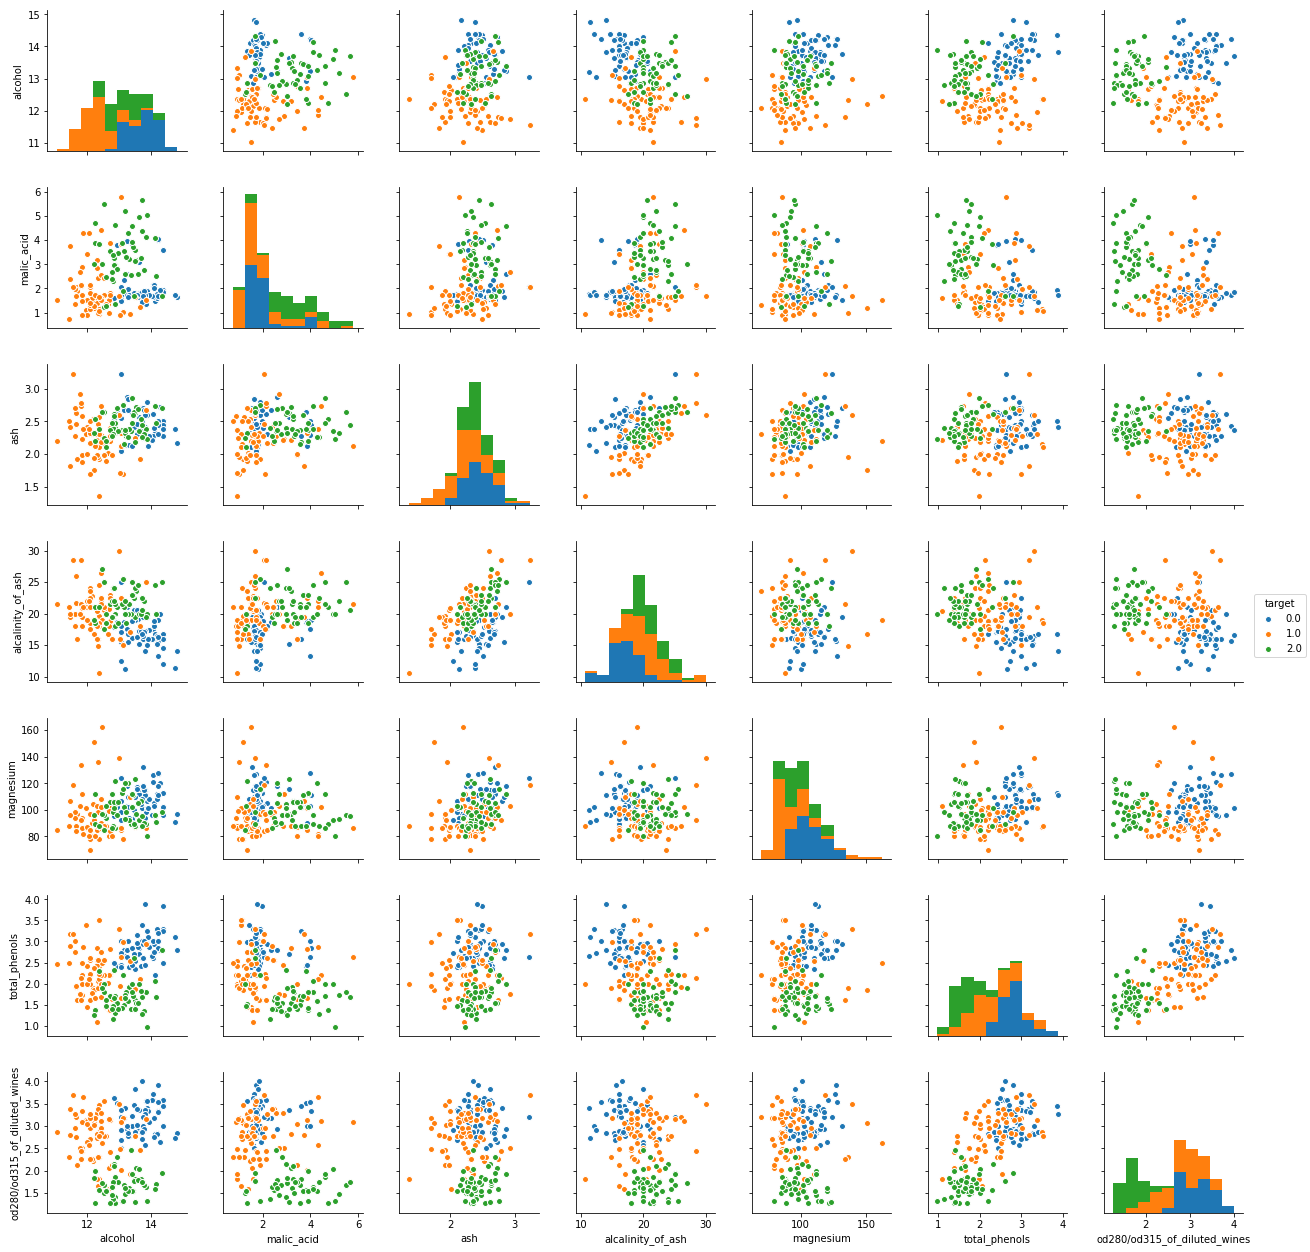

In [515]:
import matplotlib.pyplot as plt
import seaborn as sns

relationship = sns.pairplot(wine, vars=['alcohol','malic_acid','ash','alcalinity_of_ash','magnesium','total_phenols','od280/od315_of_diluted_wines'], hue='target')
plt.show(relationship)

# Implementaçao Rede Neural MLP

In [516]:
import numpy as np
import sys


class NeuralNetMLP(object):
    def __init__(self, n_hidden=2,
                 l2=0., epochs=2, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

# Proposta das arquiteturas para simulaçoes total 6

# <li>Arquitetura 1</li>
<p>
<li>Número de camadas   = 1</li>
<li>Taxa de Aprendizado = 0.001</li>
<li>Número de iterações = 100</li>
<li>Velocidade Momentun = 1</li></p>
    
# <li>Arquitetura 2</li>
<li>Número de camadas   = 2</li>
<li>Taxa de Aprendizado = 0.001</li>
<li>Número de iterações = 100</li>
<li>Velocidade Momentun = 1</li>
    
# <li>Arquitetura 3</li>
<li>Número de camadas   = 1</li>
<li>Taxa de Aprendizado = 0.0005</li>
<li>Número de iterações = 250</li>
<li>Velocidade Momentun = 1</li>
  
# <li>Arquitetura 4</li>
<li>Número de camadas   = 2</li>
<li>Taxa de Aprendizado = 0.00025</li>
<li>Número de iterações = 250</li>
<li>Velocidade Momentun = 1</li>
    
# <li>Arquitetura 5</li>
<li>Número de camadas   = 1</li>
<li>Taxa de Aprendizado = 0.0005</li>
<li>Número de iterações = 500</li>
<li>Velocidade Momentun = 0.5</li>
    
# <li>Arquitetura 6</li>
<li>Número de camadas   = 2</li>
<li>Taxa de Aprendizado = 0.00025</li>
<li>Número de iterações = 500</li>
<li>Velocidade Momentun = 0.5</li>

# <p>Implementação</p>

In [517]:
#criando as redes e suas variacoes de parametros para analise
#rede1 : iteracoes=100, camadasOcultas=1 
nn1_e100_ = NeuralNetMLP(n_hidden=1, 
                  l2=0.01, 
                  epochs=100, 
                  eta=0.001,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)
#rede2 : iteracoes=100, camadasOcultas=2 
nn2_e100_ = NeuralNetMLP(n_hidden=2, 
                  l2=0.01, 
                  epochs=100, 
                  eta=0.001,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)
#rede3 : iteracoes=250, camadasOcultas=1, TaxaAprendizado=0.0005 
nn3_e250_eta0005 = NeuralNetMLP(n_hidden=1, 
                  l2=0.01, 
                  epochs=250, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)
#rede4 : iteracoes=250, camadasOcultas=2, TaxaAprendizado=0.00025
nn4_e250_eta00025 = NeuralNetMLP(n_hidden=2, 
                  l2=0.01, 
                  epochs=250, 
                  eta=0.00025,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)
#rede5 : iteracoes=500, camadasOcultas=1, TaxaAprendizado=0.0005 Momentun=0.5
nn5_e500_eta05_m05 = NeuralNetMLP(n_hidden=1, 
                  l2=0.01, 
                  epochs=500, 
                  eta=0.0005,
                  minibatch_size=50, 
                  shuffle=True,
                  seed=1)
#rede6 : iteracoes=500, camadasOcultas=2, TaxaAprendizado=0.00025 Momentun=0.5
nn6_e500_eta025_m05 = NeuralNetMLP(n_hidden=2, 
                  l2=0.01, 
                  epochs=500, 
                  eta=0.00025,
                  minibatch_size=50, 
                  shuffle=True,
                  seed=1)

In [518]:
vinho = datasets.load_wine()
xx = vinho.data[:, [0,3,12]]
yy = vinho.target


# Dividindo os dados 70% Treinamento e 30% Teste

In [519]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.3, random_state=1, stratify=yy)

# Normalizando os dados

In [520]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Realizando os treinamentos nas diversas arquiteturas


In [521]:
#fit(self, X_train, y_train, X_valid, y_valid):
n1 = nn1_e100_.fit(X_train, y_train, X_test, y_test)


100/100 | Cost: 234.47 | Train/Valid Acc.: 40.32%/38.89% 

# Arquitetura 1 70% 
<li>Acurácia = 38.89%</li>

In [522]:
n2 = nn2_e100_.fit(X_train, y_train, X_test, y_test)

100/100 | Cost: 234.20 | Train/Valid Acc.: 40.32%/38.89% 

# Arquitetura 2
<li>Acurácia : 38.89%</li>

In [523]:
n3 = nn3_e250_eta0005.fit(X_train, y_train, X_test, y_test)


250/250 | Cost: 234.23 | Train/Valid Acc.: 40.32%/38.89% 

# Arquitetura 3
<li>Acurácia : 38.89%</li>

In [524]:
n4 = nn4_e250_eta00025.fit(X_train, y_train, X_test, y_test)

250/250 | Cost: 234.25 | Train/Valid Acc.: 40.32%/38.89% 

# Arquitetura 4
<li>Acurácia : 38.89%</li>

In [525]:
n5 = nn5_e500_eta05_m05.fit(X_train, y_train, X_test, y_test)

500/500 | Cost: 234.15 | Train/Valid Acc.: 40.32%/38.89% 

# Arquitetura 5
<li>Acurácia : 38.89%</li>

In [526]:
n6 = nn6_e500_eta025_m05.fit(X_train, y_train, X_test, y_test)

500/500 | Cost: 234.16 | Train/Valid Acc.: 40.32%/38.89% 

# Arquitetura 6
<li>Acurácia : 38.89%</li>

# Treinamento:70%  Teste:30%  Acurácia:38.89%

# Grafico Iterações x Soma Quadratica dos Erros
# Treinamento = 70% Testes = 30% 

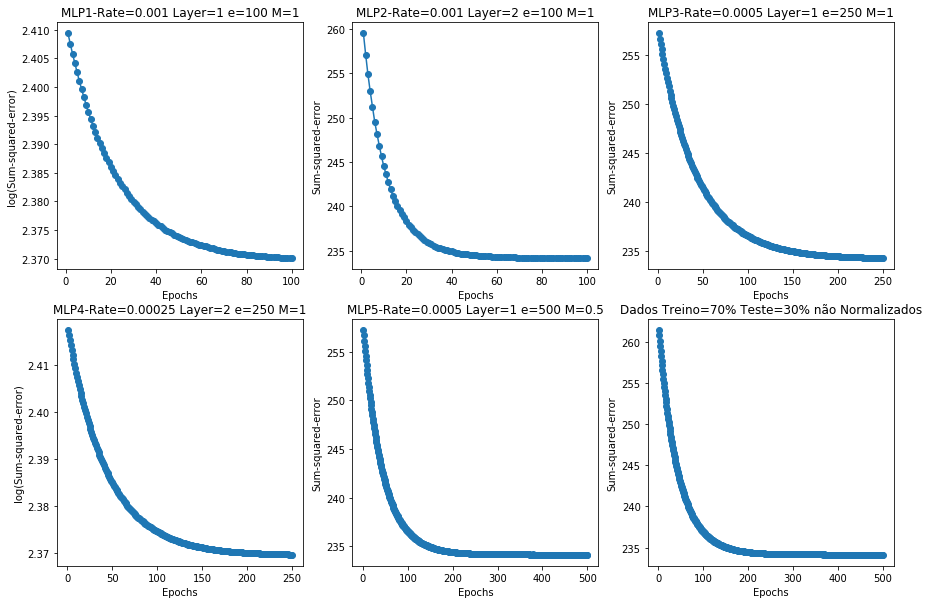

In [527]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax[0][0].plot(range(1, len(n1.eval_['cost']) + 1), np.log10(n1.eval_['cost']), marker='o')
ax[0][0].set_xlabel('Epochs')
ax[0][0].set_ylabel('log(Sum-squared-error)')
ax[0][0].set_title('MLP1-Rate=0.001 Layer=1 e=100 M=1')

ax[0][1].plot(range(1, len(n2.eval_['cost']) + 1), n2.eval_['cost'], marker='o')
ax[0][1].set_xlabel('Epochs')
ax[0][1].set_ylabel('Sum-squared-error')
ax[0][1].set_title('MLP2-Rate=0.001 Layer=2 e=100 M=1')

ax[0][2].plot(range(1, len(n3.eval_['cost']) + 1), n3.eval_['cost'], marker='o')
ax[0][2].set_xlabel('Epochs')
ax[0][2].set_ylabel('Sum-squared-error')
ax[0][2].set_title('MLP3-Rate=0.0005 Layer=1 e=250 M=1')

ax[1][0].plot(range(1, len(n4.eval_['cost']) + 1), np.log10(n4.eval_['cost']), marker='o')
ax[1][0].set_xlabel('Epochs')
ax[1][0].set_ylabel('log(Sum-squared-error)')
ax[1][0].set_title('MLP4-Rate=0.00025 Layer=2 e=250 M=1')

ax[1][1].plot(range(1, len(n5.eval_['cost']) + 1), n5.eval_['cost'], marker='o')
ax[1][1].set_xlabel('Epochs')
ax[1][1].set_ylabel('Sum-squared-error')
ax[1][1].set_title('MLP5-Rate=0.0005 Layer=1 e=500 M=0.5')

ax[1][2].plot(range(1, len(n6.eval_['cost']) + 1), n6.eval_['cost'], marker='o')
ax[1][2].set_xlabel('Epochs')
ax[1][2].set_ylabel('Sum-squared-error')
ax[1][2].set_title('MLP6-Rate=0.00025 Layer=2 e=500 M=0.5')

# plt.savefig('images/02_11.png', dpi=300)
plt.title('Dados Treino=70% Teste=30% não Normalizados')
plt.show()


# Grafico Acurácia x Iterações 

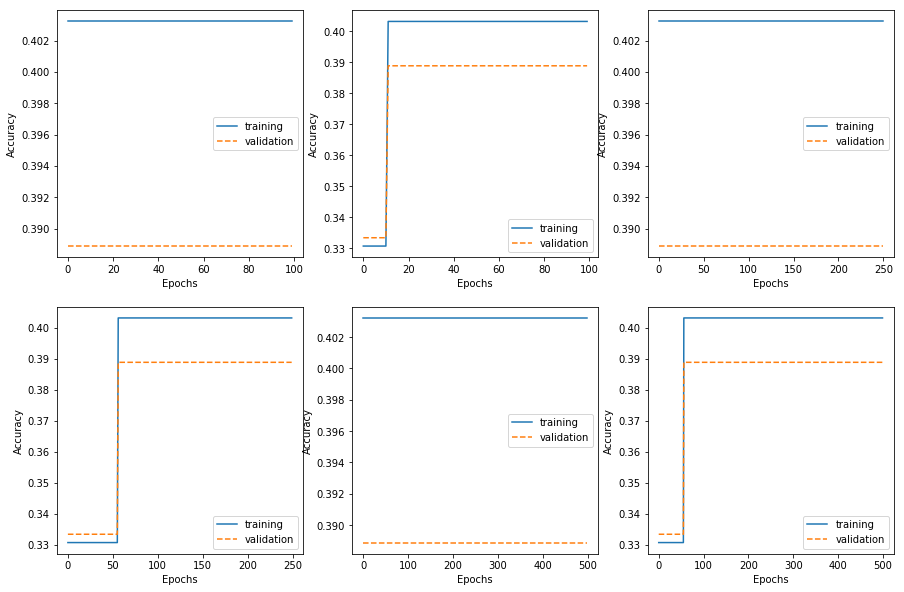

In [528]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax[0][0].plot(range(n1.epochs), n1.eval_['train_acc'], label='training')
ax[0][0].plot(range(n1.epochs), n1.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][0].set_ylabel('Accuracy')
ax[0][0].set_xlabel('Epochs')
ax[0][0].legend()
ax[0][0].set_title('')

ax[0][1].plot(range(n2.epochs), n2.eval_['train_acc'], label='training')
ax[0][1].plot(range(n2.epochs), n2.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][1].set_ylabel('Accuracy')
ax[0][1].set_xlabel('Epochs')
ax[0][1].legend()
ax[0][1].set_title('')

ax[0][2].plot(range(n3.epochs), n3.eval_['train_acc'], label='training')
ax[0][2].plot(range(n3.epochs), n3.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][2].set_ylabel('Accuracy')
ax[0][2].set_xlabel('Epochs')
ax[0][2].legend()
ax[0][2].set_title('')

ax[1][0].plot(range(n4.epochs), n4.eval_['train_acc'], label='training')
ax[1][0].plot(range(n4.epochs), n4.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][0].set_ylabel('Accuracy')
ax[1][0].set_xlabel('Epochs')
ax[1][0].legend()
ax[1][0].set_title('')

ax[1][1].plot(range(n5.epochs), n5.eval_['train_acc'], label='training')
ax[1][1].plot(range(n5.epochs), n5.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][1].set_ylabel('Accuracy')
ax[1][1].set_xlabel('Epochs')
ax[1][1].legend()
ax[1][1].set_title('')

ax[1][2].plot(range(n6.epochs), n6.eval_['train_acc'], label='training')
ax[1][2].plot(range(n6.epochs), n6.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][2].set_ylabel('Accuracy')
ax[1][2].set_xlabel('Epochs')
ax[1][2].legend()
ax[1][2].set_title('')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()
#plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
#plt.show()

# Agora Realizamos o treinamento com os dados normalizados


In [529]:
n1 = nn1_e100_.fit(X_train_std, y_train, X_test_std, y_test)

100/100 | Cost: 229.59 | Train/Valid Acc.: 40.32%/38.89% 

# Arquitetura1 30% Teste dados Normalizados
<li>Acurácia = 39%</li>

In [530]:
n2 = nn2_e100_.fit(X_train_std, y_train, X_test_std, y_test)

100/100 | Cost: 226.45 | Train/Valid Acc.: 40.32%/38.89% 

# Arquitetura2 30% Teste dados Normalizados
<li>Acurácia = 39%</li>

In [531]:
n3 = nn3_e250_eta0005.fit(X_train_std, y_train, X_test_std, y_test)

250/250 | Cost: 219.95 | Train/Valid Acc.: 44.35%/44.44% 

# Arquitetura3  30% Teste dados Normalizados
<li>Acurácia = 44.44%</li> 

In [532]:
n4 = nn4_e250_eta00025.fit(X_train_std, y_train, X_test_std, y_test)

250/250 | Cost: 233.79 | Train/Valid Acc.: 40.32%/38.89% 

# Arquitetura4 30% Teste dados Normalizados
<li>Acurácia = 38.89%</li>

In [533]:
n5 = nn5_e500_eta05_m05.fit(X_train_std, y_train, X_test_std, y_test)

500/500 | Cost: 199.61 | Train/Valid Acc.: 71.77%/61.11% 

# Arquitetura5 30% Teste dados Normalizados
<li>Acurácia = 61.11%</li>

In [534]:
n6 = nn6_e500_eta025_m05.fit(X_train_std, y_train, X_test_std, y_test)

500/500 | Cost: 209.37 | Train/Valid Acc.: 71.77%/66.67% 

# Arquitetura1 30% Teste dados Normalizados
<li>Acurácia = 66.67%</li>

# Grafico Iterações x Soma Quadratica dos Erros
# Treinamento = 70% Testes = 30% 
# Dados Normalizados

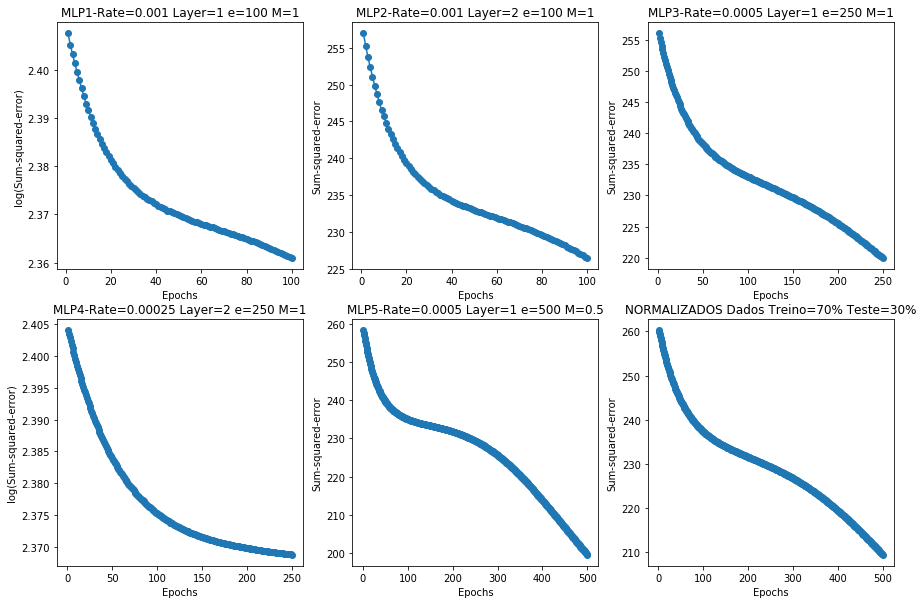

In [535]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax[0][0].plot(range(1, len(n1.eval_['cost']) + 1), np.log10(n1.eval_['cost']), marker='o')
ax[0][0].set_xlabel('Epochs')
ax[0][0].set_ylabel('log(Sum-squared-error)')
ax[0][0].set_title('MLP1-Rate=0.001 Layer=1 e=100 M=1')

ax[0][1].plot(range(1, len(n2.eval_['cost']) + 1), n2.eval_['cost'], marker='o')
ax[0][1].set_xlabel('Epochs')
ax[0][1].set_ylabel('Sum-squared-error')
ax[0][1].set_title('MLP2-Rate=0.001 Layer=2 e=100 M=1')

ax[0][2].plot(range(1, len(n3.eval_['cost']) + 1), n3.eval_['cost'], marker='o')
ax[0][2].set_xlabel('Epochs')
ax[0][2].set_ylabel('Sum-squared-error')
ax[0][2].set_title('MLP3-Rate=0.0005 Layer=1 e=250 M=1')

ax[1][0].plot(range(1, len(n4.eval_['cost']) + 1), np.log10(n4.eval_['cost']), marker='o')
ax[1][0].set_xlabel('Epochs')
ax[1][0].set_ylabel('log(Sum-squared-error)')
ax[1][0].set_title('MLP4-Rate=0.00025 Layer=2 e=250 M=1')

ax[1][1].plot(range(1, len(n5.eval_['cost']) + 1), n5.eval_['cost'], marker='o')
ax[1][1].set_xlabel('Epochs')
ax[1][1].set_ylabel('Sum-squared-error')
ax[1][1].set_title('MLP5-Rate=0.0005 Layer=1 e=500 M=0.5')

ax[1][2].plot(range(1, len(n6.eval_['cost']) + 1), n6.eval_['cost'], marker='o')
ax[1][2].set_xlabel('Epochs')
ax[1][2].set_ylabel('Sum-squared-error')
ax[1][2].set_title('MLP6-Rate=0.00025 Layer=2 e=500 M=0.5')

plt.title('NORMALIZADOS Dados Treino=70% Teste=30%')
# plt.savefig('images/02_11.png', dpi=300)
plt.show()

# Grafico Acurácia x Iterações Dados Normalizados

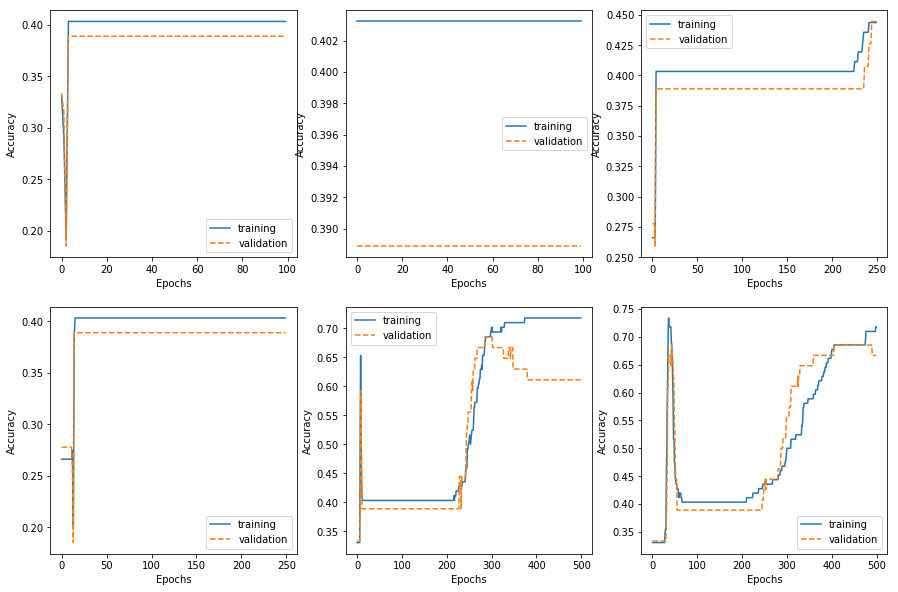

In [536]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax[0][0].plot(range(n1.epochs), n1.eval_['train_acc'], label='training')
ax[0][0].plot(range(n1.epochs), n1.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][0].set_ylabel('Accuracy')
ax[0][0].set_xlabel('Epochs')
ax[0][0].legend()
ax[0][0].set_title('')

ax[0][1].plot(range(n2.epochs), n2.eval_['train_acc'], label='training')
ax[0][1].plot(range(n2.epochs), n2.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][1].set_ylabel('Accuracy')
ax[0][1].set_xlabel('Epochs')
ax[0][1].legend()
ax[0][1].set_title('')

ax[0][2].plot(range(n3.epochs), n3.eval_['train_acc'], label='training')
ax[0][2].plot(range(n3.epochs), n3.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][2].set_ylabel('Accuracy')
ax[0][2].set_xlabel('Epochs')
ax[0][2].legend()
ax[0][2].set_title('')

ax[1][0].plot(range(n4.epochs), n4.eval_['train_acc'], label='training')
ax[1][0].plot(range(n4.epochs), n4.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][0].set_ylabel('Accuracy')
ax[1][0].set_xlabel('Epochs')
ax[1][0].legend()
ax[1][0].set_title('')

ax[1][1].plot(range(n5.epochs), n5.eval_['train_acc'], label='training')
ax[1][1].plot(range(n5.epochs), n5.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][1].set_ylabel('Accuracy')
ax[1][1].set_xlabel('Epochs')
ax[1][1].legend()
ax[1][1].set_title('')

ax[1][2].plot(range(n6.epochs), n6.eval_['train_acc'], label='training')
ax[1][2].plot(range(n6.epochs), n6.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][2].set_ylabel('Accuracy')
ax[1][2].set_xlabel('Epochs')
ax[1][2].legend()
ax[1][2].set_title('')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()
#plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
#plt.show()

In [538]:
y_test_pred = n1.predict(X_test_std)
ac1 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])
#print('Test accuracy: %.2f%%' % (ac1 * 100))
y_test_pred = n2.predict(X_test_std)
ac2 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

#print('Test accuracy: %.2f%%' % (ac2 * 100))
y_test_pred = n3.predict(X_test_std)
ac3 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

#print('Test accuracy: %.2f%%' % (ac3 * 100))
y_test_pred = n4.predict(X_test_std)
ac4 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

#print('Test accuracy: %.2f%%' % (ac4 * 100))
y_test_pred = n5.predict(X_test_std)
ac5 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

#print('Test accuracy: %.2f%%' % (ac5 * 100))
y_test_pred = n6.predict(X_test_std)
ac6 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

#print('Test accuracy: %.2f%%' % (ac6 * 100))
b1 = [(ac1 * 100), (ac2 * 100), (ac3 * 100), (ac4 * 100), (ac5 * 100), (ac6 * 100)]
t1 =[[a[0],b1[0]],
    [a[1],b1[1]],
    [a[2],b1[2]],
    [a[3],b1[3]],
    [a[4],b1[4]],
    [a[5],b1[5]]]



# Alterando a proporção dos dados para treinamento e teste
# Treinamento = 85% Testes = 15%

In [539]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.15, random_state=1, stratify=yy)

# Normalizando

In [540]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Treinando com nova proporção Treinamento = 85% Testes = 15%

In [541]:
n1 = nn1_e100_.fit(X_train, y_train, X_test, y_test)

100/100 | Cost: 285.96 | Train/Valid Acc.: 39.74%/40.74% 

In [542]:
n2 = nn2_e100_.fit(X_train, y_train, X_test, y_test)

100/100 | Cost: 285.66 | Train/Valid Acc.: 39.74%/40.74% 

In [543]:
n3 = nn3_e250_eta0005.fit(X_train, y_train, X_test, y_test)

250/250 | Cost: 285.73 | Train/Valid Acc.: 39.74%/40.74% 

In [544]:
n4 = nn4_e250_eta00025.fit(X_train, y_train, X_test, y_test)

250/250 | Cost: 285.74 | Train/Valid Acc.: 39.74%/40.74% 

In [545]:
n5 = nn5_e500_eta05_m05.fit(X_train, y_train, X_test, y_test)

500/500 | Cost: 285.64 | Train/Valid Acc.: 39.74%/40.74% 

In [546]:
n6 = nn6_e500_eta025_m05.fit(X_train, y_train, X_test, y_test)

500/500 | Cost: 285.65 | Train/Valid Acc.: 39.74%/40.74% 

# Treinamento 85% e Teste  15% 

# <li>Arquitetura 1</li> 
<li>Acurácia = 40.74%</li>

# <li>Arquitetura 2</li> 
<li>Acurácia = 40.74%</li>

# <li>Arquitetura 3</li> 
<li>Acurácia = 40.74%</li>

# <li>Arquitetura 4</li> 
<li>Acurácia = 40.74%</li>

# <li>Arquitetura 5</li> 
<li>Acurácia = 40.74%</li>

# <li>Arquitetura 6</li> 
<li>Acurácia = 40.74%</li>

# Treinamento:85% Teste:15% Acurácia:40.74%

# Grafico Iterações x Soma Quadratica dos Erros
# Treinamento = 85% Testes = 15% 

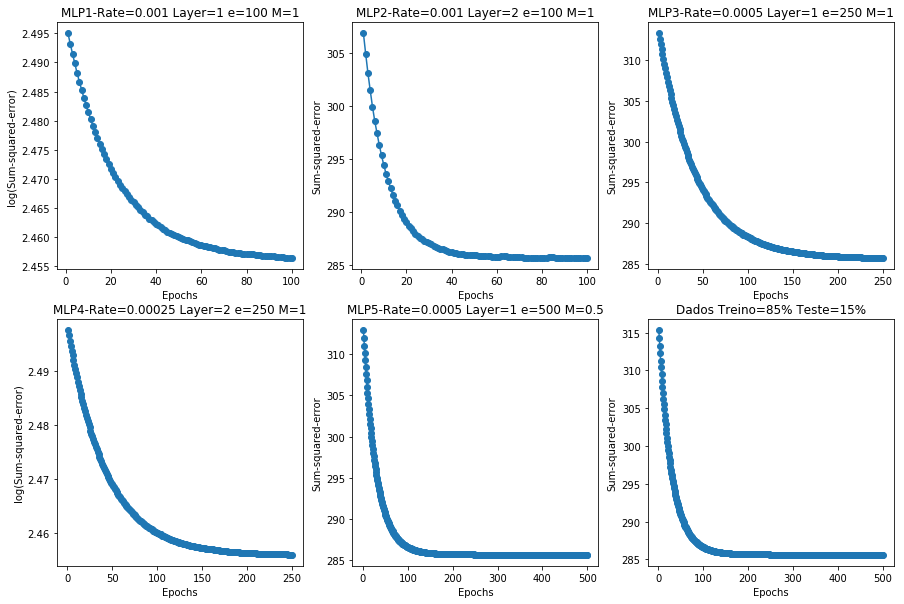

In [547]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax[0][0].plot(range(1, len(n1.eval_['cost']) + 1), np.log10(n1.eval_['cost']), marker='o')
ax[0][0].set_xlabel('Epochs')
ax[0][0].set_ylabel('log(Sum-squared-error)')
ax[0][0].set_title('MLP1-Rate=0.001 Layer=1 e=100 M=1')

ax[0][1].plot(range(1, len(n2.eval_['cost']) + 1), n2.eval_['cost'], marker='o')
ax[0][1].set_xlabel('Epochs')
ax[0][1].set_ylabel('Sum-squared-error')
ax[0][1].set_title('MLP2-Rate=0.001 Layer=2 e=100 M=1')

ax[0][2].plot(range(1, len(n3.eval_['cost']) + 1), n3.eval_['cost'], marker='o')
ax[0][2].set_xlabel('Epochs')
ax[0][2].set_ylabel('Sum-squared-error')
ax[0][2].set_title('MLP3-Rate=0.0005 Layer=1 e=250 M=1')

ax[1][0].plot(range(1, len(n4.eval_['cost']) + 1), np.log10(n4.eval_['cost']), marker='o')
ax[1][0].set_xlabel('Epochs')
ax[1][0].set_ylabel('log(Sum-squared-error)')
ax[1][0].set_title('MLP4-Rate=0.00025 Layer=2 e=250 M=1')

ax[1][1].plot(range(1, len(n5.eval_['cost']) + 1), n5.eval_['cost'], marker='o')
ax[1][1].set_xlabel('Epochs')
ax[1][1].set_ylabel('Sum-squared-error')
ax[1][1].set_title('MLP5-Rate=0.0005 Layer=1 e=500 M=0.5')

ax[1][2].plot(range(1, len(n6.eval_['cost']) + 1), n6.eval_['cost'], marker='o')
ax[1][2].set_xlabel('Epochs')
ax[1][2].set_ylabel('Sum-squared-error')
ax[1][2].set_title('MLP6-Rate=0.00025 Layer=2 e=500 M=0.5')

plt.title('Dados Treino=85% Teste=15%')
# plt.savefig('images/02_11.png', dpi=300)
plt.show()

# Grafico Iterações x Soma Quadratica dos Erros
# Treinamento = 85% Testes = 15%

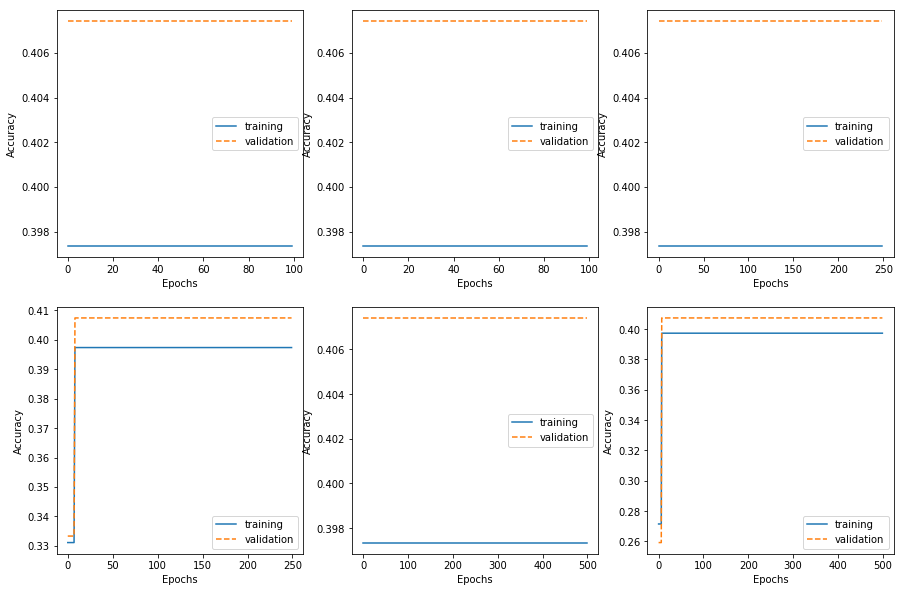

In [548]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax[0][0].plot(range(n1.epochs), n1.eval_['train_acc'], label='training')
ax[0][0].plot(range(n1.epochs), n1.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][0].set_ylabel('Accuracy')
ax[0][0].set_xlabel('Epochs')
ax[0][0].legend()
ax[0][0].set_title('')

ax[0][1].plot(range(n2.epochs), n2.eval_['train_acc'], label='training')
ax[0][1].plot(range(n2.epochs), n2.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][1].set_ylabel('Accuracy')
ax[0][1].set_xlabel('Epochs')
ax[0][1].legend()
ax[0][1].set_title('')

ax[0][2].plot(range(n3.epochs), n3.eval_['train_acc'], label='training')
ax[0][2].plot(range(n3.epochs), n3.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][2].set_ylabel('Accuracy')
ax[0][2].set_xlabel('Epochs')
ax[0][2].legend()
ax[0][2].set_title('')

ax[1][0].plot(range(n4.epochs), n4.eval_['train_acc'], label='training')
ax[1][0].plot(range(n4.epochs), n4.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][0].set_ylabel('Accuracy')
ax[1][0].set_xlabel('Epochs')
ax[1][0].legend()
ax[1][0].set_title('')

ax[1][1].plot(range(n5.epochs), n5.eval_['train_acc'], label='training')
ax[1][1].plot(range(n5.epochs), n5.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][1].set_ylabel('Accuracy')
ax[1][1].set_xlabel('Epochs')
ax[1][1].legend()
ax[1][1].set_title('')

ax[1][2].plot(range(n6.epochs), n6.eval_['train_acc'], label='training')
ax[1][2].plot(range(n6.epochs), n6.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][2].set_ylabel('Accuracy')
ax[1][2].set_xlabel('Epochs')
ax[1][2].legend()
ax[1][2].set_title('')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()
#plt.legend()
#plt.savefig(

# Treinamento com os dados Normalizados...

In [549]:
n1 = nn1_e100_.fit(X_train_std, y_train, X_test_std, y_test)

100/100 | Cost: 285.69 | Train/Valid Acc.: 39.74%/40.74% 

In [550]:
n2 = nn2_e100_.fit(X_train_std, y_train, X_test_std, y_test)

100/100 | Cost: 276.65 | Train/Valid Acc.: 43.71%/48.15% 

In [551]:
n3 = nn3_e250_eta0005.fit(X_train_std, y_train, X_test_std, y_test)

250/250 | Cost: 282.91 | Train/Valid Acc.: 39.74%/40.74% 

In [552]:
n4 = nn4_e250_eta00025.fit(X_train_std, y_train, X_test_std, y_test)

250/250 | Cost: 285.75 | Train/Valid Acc.: 39.74%/40.74% 

In [553]:
n5 = nn5_e500_eta05_m05.fit(X_train_std, y_train, X_test_std, y_test)

500/500 | Cost: 233.76 | Train/Valid Acc.: 68.87%/66.67% 

In [554]:
n6 = nn6_e500_eta025_m05.fit(X_train_std, y_train, X_test_std, y_test)

500/500 | Cost: 252.13 | Train/Valid Acc.: 70.20%/66.67% 

# Treinamento 85% e Teste  15%  Dados Normalizados

# <li>Arquitetura 1</li> 
<li>Acurácia = 40.74%</li>

# <li>Arquitetura 2</li> 
<li>Acurácia = 48.15%</li>

# <li>Arquitetura 3</li> 
<li>Acurácia = 40.74%</li>

# <li>Arquitetura 4</li> 
<li>Acurácia = 40.74%</li>

# <li>Arquitetura 5</li> 
<li>Acurácia = 66.67%</li>

# <li>Arquitetura 6</li> 
<li>Acurácia = 70.37%</li>

# Grafico Iterações x Soma Quadratica dos Erros
# Treinamento = 85% Testes = 15% 
# Dados Normalizados

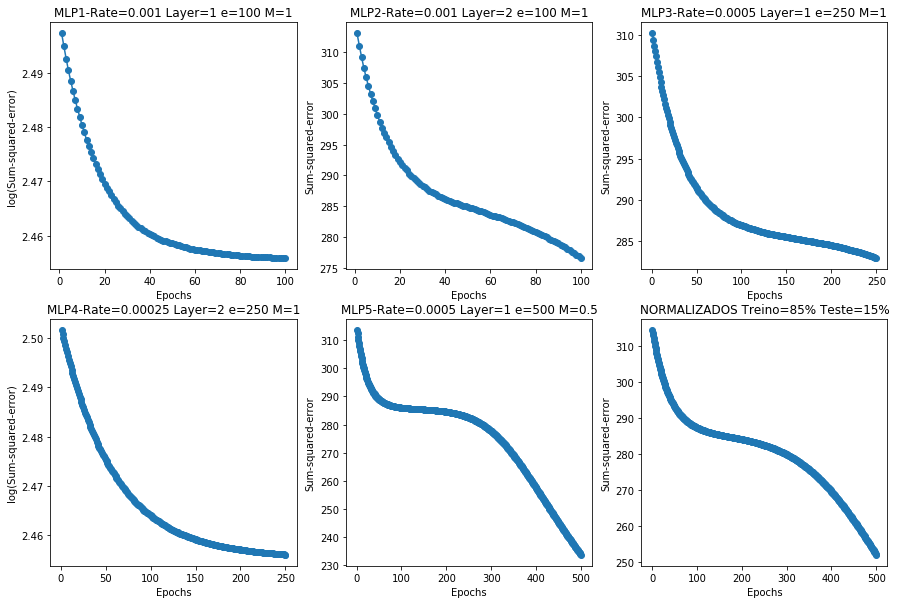

In [555]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax[0][0].plot(range(1, len(n1.eval_['cost']) + 1), np.log10(n1.eval_['cost']), marker='o')
ax[0][0].set_xlabel('Epochs')
ax[0][0].set_ylabel('log(Sum-squared-error)')
ax[0][0].set_title('MLP1-Rate=0.001 Layer=1 e=100 M=1')

ax[0][1].plot(range(1, len(n2.eval_['cost']) + 1), n2.eval_['cost'], marker='o')
ax[0][1].set_xlabel('Epochs')
ax[0][1].set_ylabel('Sum-squared-error')
ax[0][1].set_title('MLP2-Rate=0.001 Layer=2 e=100 M=1')

ax[0][2].plot(range(1, len(n3.eval_['cost']) + 1), n3.eval_['cost'], marker='o')
ax[0][2].set_xlabel('Epochs')
ax[0][2].set_ylabel('Sum-squared-error')
ax[0][2].set_title('MLP3-Rate=0.0005 Layer=1 e=250 M=1')

ax[1][0].plot(range(1, len(n4.eval_['cost']) + 1), np.log10(n4.eval_['cost']), marker='o')
ax[1][0].set_xlabel('Epochs')
ax[1][0].set_ylabel('log(Sum-squared-error)')
ax[1][0].set_title('MLP4-Rate=0.00025 Layer=2 e=250 M=1')

ax[1][1].plot(range(1, len(n5.eval_['cost']) + 1), n5.eval_['cost'], marker='o')
ax[1][1].set_xlabel('Epochs')
ax[1][1].set_ylabel('Sum-squared-error')
ax[1][1].set_title('MLP5-Rate=0.0005 Layer=1 e=500 M=0.5')

ax[1][2].plot(range(1, len(n6.eval_['cost']) + 1), n6.eval_['cost'], marker='o')
ax[1][2].set_xlabel('Epochs')
ax[1][2].set_ylabel('Sum-squared-error')
ax[1][2].set_title('MLP6-Rate=0.00025 Layer=2 e=500 M=0.5')

plt.title('NORMALIZADOS Treino=85% Teste=15%')
# plt.savefig('images/02_11.png', dpi=300)
plt.show()

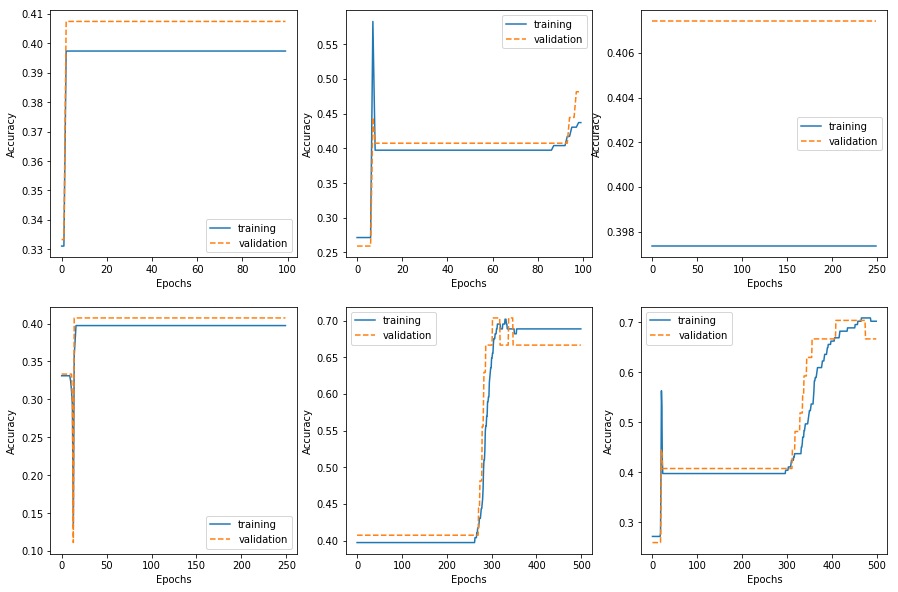

In [556]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax[0][0].plot(range(n1.epochs), n1.eval_['train_acc'], label='training')
ax[0][0].plot(range(n1.epochs), n1.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][0].set_ylabel('Accuracy')
ax[0][0].set_xlabel('Epochs')
ax[0][0].legend()
ax[0][0].set_title('')

ax[0][1].plot(range(n2.epochs), n2.eval_['train_acc'], label='training')
ax[0][1].plot(range(n2.epochs), n2.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][1].set_ylabel('Accuracy')
ax[0][1].set_xlabel('Epochs')
ax[0][1].legend()
ax[0][1].set_title('')

ax[0][2].plot(range(n3.epochs), n3.eval_['train_acc'], label='training')
ax[0][2].plot(range(n3.epochs), n3.eval_['valid_acc'], label='validation', linestyle='--')
ax[0][2].set_ylabel('Accuracy')
ax[0][2].set_xlabel('Epochs')
ax[0][2].legend()
ax[0][2].set_title('')

ax[1][0].plot(range(n4.epochs), n4.eval_['train_acc'], label='training')
ax[1][0].plot(range(n4.epochs), n4.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][0].set_ylabel('Accuracy')
ax[1][0].set_xlabel('Epochs')
ax[1][0].legend()
ax[1][0].set_title('')

ax[1][1].plot(range(n5.epochs), n5.eval_['train_acc'], label='training')
ax[1][1].plot(range(n5.epochs), n5.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][1].set_ylabel('Accuracy')
ax[1][1].set_xlabel('Epochs')
ax[1][1].legend()
ax[1][1].set_title('')

ax[1][2].plot(range(n6.epochs), n6.eval_['train_acc'], label='training')
ax[1][2].plot(range(n6.epochs), n6.eval_['valid_acc'], label='validation', linestyle='--')
ax[1][2].set_ylabel('Accuracy')
ax[1][2].set_xlabel('Epochs')
ax[1][2].legend()
ax[1][2].set_title('')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()
#plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
#plt.show()

In [558]:
a = ["Arquitetura-1","Arquitetura-2","Arquitetura-3","Arquitetura-4","Arquitetura-5","Arquitetura-6"]


In [570]:
y_test_pred = n1.predict(X_test_std)
ac1 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])
#print('Test accuracy: %.2f%%' % (ac1 * 100))
y_test_pred = n2.predict(X_test_std)
ac2 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

#print('Test accuracy: %.2f%%' % (ac2 * 100))
y_test_pred = n3.predict(X_test_std)
ac3 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

#print('Test accuracy: %.2f%%' % (ac3 * 100))
y_test_pred = n4.predict(X_test_std)
ac4 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

#print('Test accuracy: %.2f%%' % (ac4 * 100))
y_test_pred = n5.predict(X_test_std)
ac5 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

#print('Test accuracy: %.2f%%' % (ac5 * 100))
y_test_pred = n6.predict(X_test_std)
ac6 = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

#print('Test accuracy: %.2f%%' % (ac6 * 100))
b = [(ac1 * 100), (ac2 * 100), (ac3 * 100), (ac4 * 100), (ac5 * 100), (ac6 * 100)]
t =[[a[0],b[0]],
    [a[1],b[1]],
    [a[2],b[2]],
    [a[3],b[3]],
    [a[4],b[4]],
    [a[5],b[5]]]




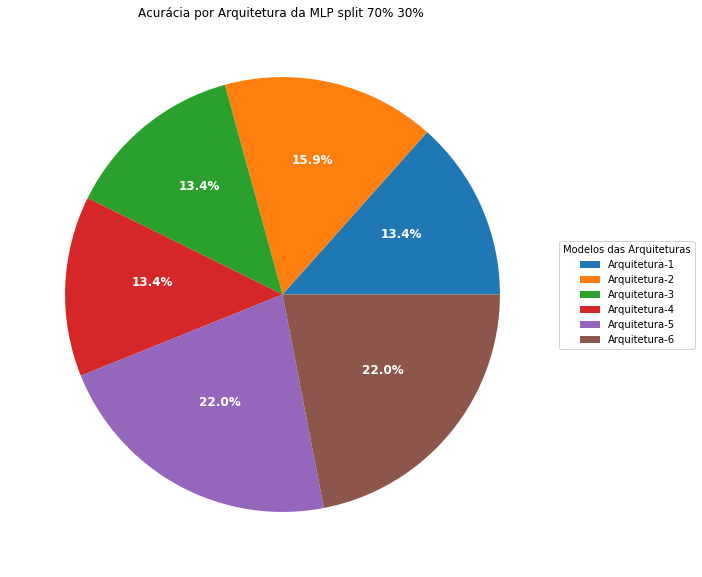

In [571]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(aspect="equal"))

data = [float(x[1]) for x in t]
ingredients = [x[0] for x in t]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Modelos das Arquiteturas",
          loc="center left",
          bbox_to_anchor=(1, 0, 1, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Acurácia por Arquitetura da MLP split 70% 30% ")

plt.show()

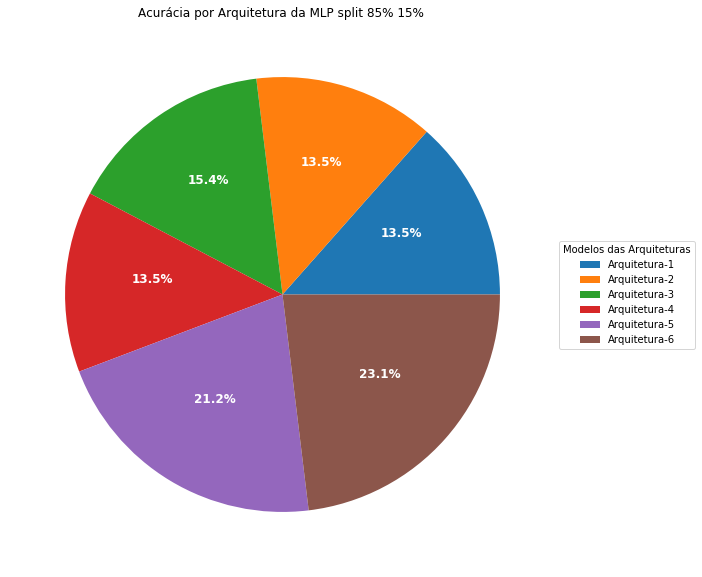

In [562]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(aspect="equal"))

data = [float(x[1]) for x in t1]
ingredients = [x[0] for x in t1]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Modelos das Arquiteturas",
          loc="center left",
          bbox_to_anchor=(1, 0, 1, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Acurácia por Arquitetura da MLP split 85% 15% ")

plt.show()

In [563]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [564]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0)

lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train, y_train))
print('Test accuracy:', lr.score(X_test, y_test))

Training accuracy: 0.33112582781456956
Test accuracy: 0.3333333333333333


In [565]:
lr.intercept_

array([-1.62397005, -1.28840171, -1.21915163])

In [566]:
np.set_printoptions(8)

In [567]:
lr.coef_[lr.coef_!=0].shape

(9,)

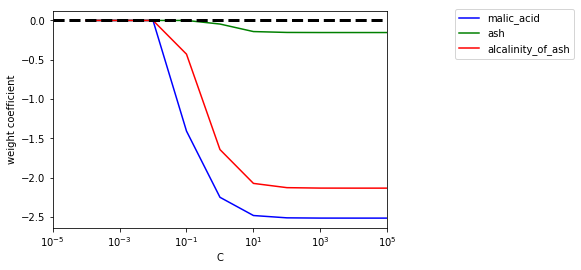

In [568]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03),ncol=1, fancybox=True)

plt.savefig('04_07.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()